<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/cancellations3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders==2.*
!pip install eli5

!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

import eli5
from eli5.sklearn import PermutationImportance

# Load dataset
url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)

# Correct some target values -- should be 'no-show' or 'cancellation' when checkout and
# arrival dates same indicating no stay
df = tools.fixTarget(df)

# Prepare training, validation, and test sets
X = df.drop('reservation_status', axis=1)
y= df['reservation_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2,
                                                  random_state=42, stratify=y_train)

     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 
--2020-06-10 19:54:14--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8853 (8.6K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]   8.65K  --.-KB/s    in 0s      

2020-06-10 19:54:14 (91.6 MB/s) - ‘tools.py’ saved [8853/8853]



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/

In [0]:
import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
tools.wrangleData(max_cardinality=50).transform(X_train).sample(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
53885,City Hotel,179,27,2.0,BB,Groups,0,0,0,Non Refund,0,Transient,65.00,0,0,2.0,False
28322,Resort Hotel,60,40,2.0,BB,Online TA,0,0,0,No Deposit,0,Transient,101.75,0,2,4.0,False
48758,City Hotel,112,14,2.0,BB,Groups,0,0,0,Non Refund,0,Transient,64.00,0,0,2.0,False
111729,City Hotel,221,19,2.0,BB,Online TA,0,0,0,No Deposit,0,Transient-Party,138.60,0,1,4.0,False
35561,Resort Hotel,28,16,2.0,BB,Offline TA/TO,0,0,0,No Deposit,0,Contract,50.86,0,0,10.0,False
96216,City Hotel,4,36,3.0,BB,Online TA,0,0,0,No Deposit,0,Transient,184.00,1,0,1.0,False
10896,Resort Hotel,124,15,2.0,HB,Groups,0,0,0,Non Refund,0,Transient,80.00,0,0,7.0,False
59412,City Hotel,464,44,2.0,BB,Groups,0,0,0,Non Refund,391,Transient,65.00,0,0,2.0,False
112618,City Hotel,10,21,2.0,SC,Online TA,0,0,0,No Deposit,0,Transient,107.10,0,0,3.0,False
94894,City Hotel,135,33,2.0,SC,Online TA,0,0,0,No Deposit,0,Transient,103.50,0,1,3.0,False


In [0]:
y_train = y_train != 'Check-Out'
y_val = y_val != 'Check-Out'
y_test = y_test != 'Check-Out'

In [8]:
from sklearn.utils import compute_class_weight
weights = compute_class_weight('balanced', y_train.unique(), y_train)
weights

array([1.32860379, 0.80171235])

In [0]:
from imblearn.under_sampling import RandomUnderSampler


In [12]:

from xgboost import XGBClassifier

xg_pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            RandomUnderSampler(),
                            XGBClassifier(random_state=42,
                                          n_estimators=1500,
                                          max_depth=5,
                                          learning_rate=0.25,
                                          n_jobs=-1))

tools.tryModel(xg_pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 91.51485237368752 %
Validate score = 84.09811546515105 %




'Confusion Matrix'

,False,True
False,8885,1540
True,1118,5172


'Metrics'

,precision,recall,f1-score
False,0.888234,0.852278,0.869884
True,0.770560,0.822258,0.795570


In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [32]:
xg_pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            RandomUnderSampler(),
                            XGBClassifier(random_state=42,
                                          n_jobs=-1))

params = {"xgbclassifier__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
          "xgbclassifier__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ],
          "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "xgbclassifier__max_leaves"       : [0, 2, 4, 8, 10]}

search = RandomizedSearchCV(xg_pipeline1, params, n_iter=100, scoring='recall', n_jobs=-1,
                            random_state=42, verbose=10, cv=3)
search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('wrangledata',
                                              wrangleData(max_cardinality=50,
                                                          remove_dates=True)),
                                             ('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
           

In [33]:
search.best_params_

{'xgbclassifier__colsample_bytree': 0.7,
 'xgbclassifier__gamma': 0.3,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 15,
 'xgbclassifier__max_leaves': 8,
 'xgbclassifier__min_child_weight': 1}

In [34]:
search.best_score_

0.8201979253606773

In [35]:
xg_pipeline2 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            RandomUnderSampler(),
                            XGBClassifier(random_state=42,
                                          n_jobs=-1,
                                          colsample_bytree=0.7,
                                          gamma=0.3,
                                          learning_rate=0.2,
                                          max_depth=15,
                                          max_leaves=8,
                                          min_child_weight=1))

tools.tryModel(xg_pipeline2, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 93.51162164587633 %
Validate score = 84.17588991923422 %




'Confusion Matrix'

,False,True
False,8863,1562
True,1083,5207


'Metrics'

,precision,recall,f1-score
False,0.891112,0.850168,0.870159
True,0.769242,0.827822,0.797458


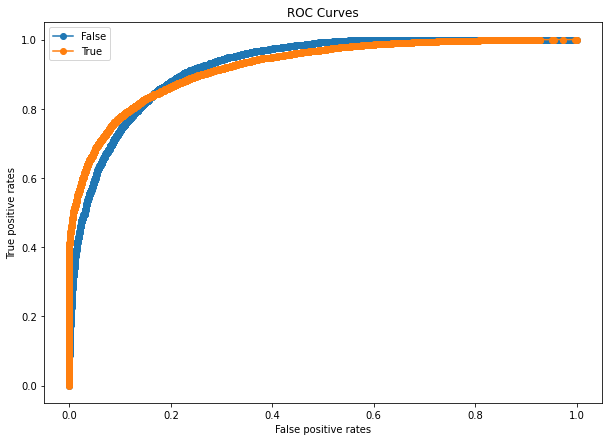

In [36]:
model = xg_pipeline2.named_steps['xgbclassifier']
wrang = xg_pipeline2.named_steps['wrangledata']
tools.ROCcurves(y_val, X_val, xg_pipeline2, classes=model.classes_)

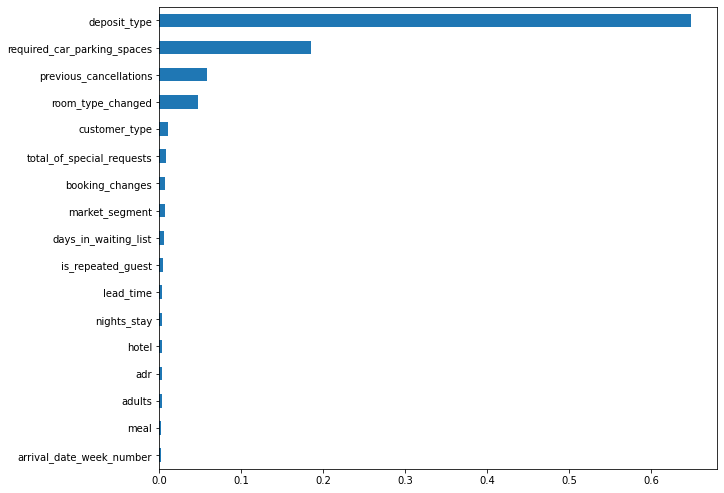

In [37]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, wrang.columns_)
plt.figure(figsize=(10, len(wrang.columns_) / 2))
importances.sort_values().plot.barh();

In [0]:
def permutationImports(model):
    # Pipeline for transformers alone
    transformers = make_pipeline(tools.wrangleData(max_cardinality=50),
                                ce.OrdinalEncoder(),
                                SimpleImputer())

    X_train_transformed = transformers.fit_transform(X_train)
    X_val_transformed = transformers.transform(X_val)

    # SMOTE resample on the training data
    X_train_resample, y_train_resample = SMOTE(random_state=42).fit_sample(X_train_transformed,
                                                                          y_train)
    # fit the  model
    model.fit(X_train_resample, y_train_resample)

    # We'll look at the importances for both accuracy score and recall
    permuter = PermutationImportance(
        model,
        scoring='accuracy',
        random_state=42
    )

    permuter1 = PermutationImportance(
        model,
        scoring='recall',
        random_state=42
    )

    permuter.fit(X_val_transformed, y_val)
    permuter1.fit(X_val_transformed, y_val)

    wrangler = transformers.named_steps['wrangledata']

    print('Accuracy score\n')
    permute_scores = pd.Series(permuter.feature_importances_, wrangler.columns_)
    display(permute_scores.sort_values(ascending=False))
    print('\n')

    plt.figure(figsize=(10, len(wrangler.columns_) / 2))
    permute_scores.sort_values().plot.barh()
    plt.show()

    print('\nRecall scores\n')
    permute1_scores = pd.Series(permuter1.feature_importances_, wrangler.columns_)
    display(permute1_scores.sort_values(ascending=False))
    print('\n')

    plt.figure(figsize=(10, len(wrangler.columns_) / 2))
    permute1_scores.sort_values().plot.barh()
    plt.show()

    return permute_scores, permute1_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy score



deposit_type                   0.078935
lead_time                      0.061585
total_of_special_requests      0.055076
market_segment                 0.036039
adr                            0.032462
previous_cancellations         0.031947
arrival_date_week_number       0.022363
customer_type                  0.022196
nights_stay                    0.021550
room_type_changed              0.018319
required_car_parking_spaces    0.013712
booking_changes                0.013628
hotel                          0.011020
meal                           0.006282
adults                         0.004571
is_repeated_guest              0.003326
days_in_waiting_list           0.001161
dtype: float64

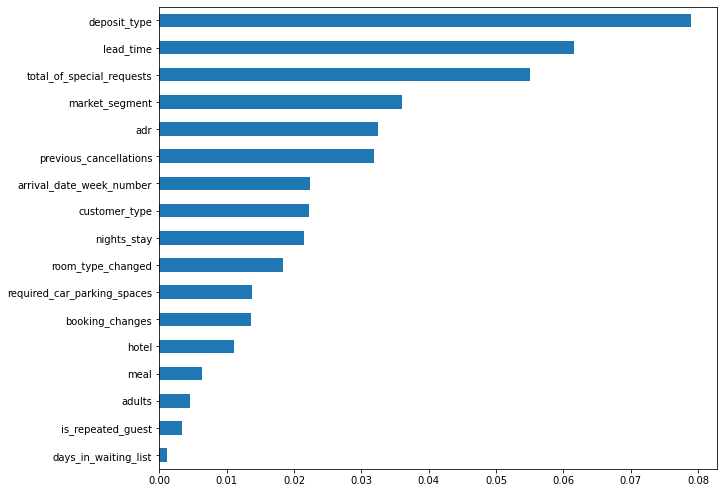


Recall scores



market_segment                 0.095866
adr                            0.085660
lead_time                      0.076852
customer_type                  0.070461
deposit_type                   0.048045
room_type_changed              0.045564
total_of_special_requests      0.040604
arrival_date_week_number       0.039491
required_car_parking_spaces    0.026582
nights_stay                    0.026010
booking_changes                0.023847
previous_cancellations         0.021431
meal                           0.016216
hotel                          0.014308
is_repeated_guest              0.009634
days_in_waiting_list           0.004070
adults                         0.002957
dtype: float64

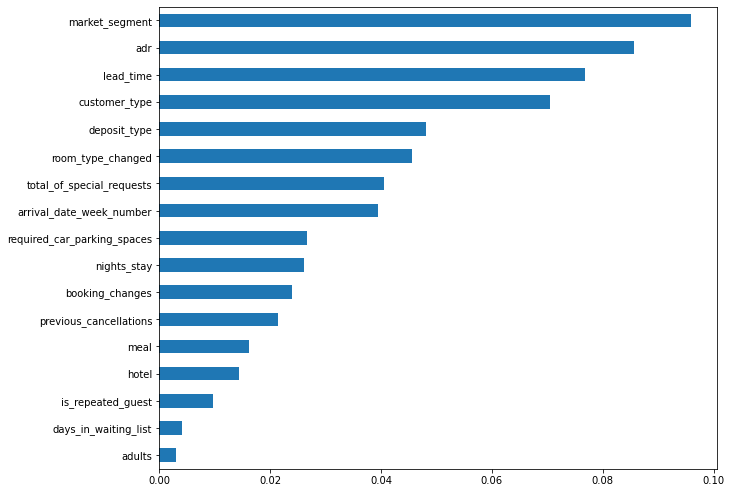

In [39]:
xg_model = XGBClassifier(random_state=42,
                        n_jobs=-1,
                        colsample_bytree=0.7,
                        gamma=0.3,
                        learning_rate=0.2,
                        max_depth=15,
                        max_leaves=5,
                        min_child_weight=1)

acc_scores, recall_scores = permutationImports(xg_model)

In [0]:
y_pred = xg_pipeline2.predict(X_test)

In [41]:
results = tools.class_metrics(y_test, y_pred)
results[0]

,True,False
True,11150,2329
False,3189,19149


In [42]:
results[1]

,precision,recall,f1-score
True,0.777600,0.827213,0.801639
False,0.891563,0.857239,0.874064


In [43]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy = {accuracy * 100} %')

Accuracy = 84.59390792081972 %
